# Aperture size calibration

Use Illumination values to estimate the f-numbers $N$ of the lens at different sizes.

Assume the first f-stop is f/6 and that the intensity $I \propto A$ where $A$ is the aperture area, hence $I \propto N^{-2}$.

To retrieve intensity, assume $I \times \Delta t = E$, where $E$ is the exposure or the pixel values for pixel values in range.

In [1]:
import numpy as np
from skimage import io
import matplotlib.pyplot as plt

In [2]:
image_path =  '../../OPT Shared files/1_Data/2023-02-08/2023-02-08 aperture calibration/MMStack_Pos0.ome.tif'
im = io.imread(image_path)
exposure_times = np.array([8, 14, 25, 60, 145,475,2250])

im.shape

(70, 1392, 1040)

Each image was taken 5 times. Perform the averaging operation.

In [3]:
def get_averaged_stack(im_stack, num_repeats):
    # Gets averaged image stack, assuming shape of image stack is (num_repeats * z_stack_depth, im_height, im_width)
    # num_repeats (int): number of averaged images
    num_repeats = int(num_repeats)

    dim_0, im_length, im_width = im_stack.shape
    reshaped = im_stack.reshape(dim_0//num_repeats, num_repeats, im_length, im_width)
    output = np.mean(reshaped, axis=1)
    return output
    
num_repeats = 5

im = get_averaged_stack(im, num_repeats=5)

subtract background

In [4]:
lights = im[::2] # light images
darks = im[1::2] # dark images
subtracted = lights - darks

Dark images look about the same

In [5]:
print(np.mean(np.reshape(darks, (7,-1)).T, axis=0))
print(np.min(np.reshape(darks, (7,-1)).T, axis=0))
print(np.max(np.reshape(darks, (7,-1)).T, axis=0))

[479.97227688 479.86251105 478.2803621  478.2947925  478.55194891
 477.36890197 477.2176155 ]
[433.  426.2 431.2 433.2 433.4 433.2 424.2]
[ 542.   554.   563.2  635.2  889.8 1756.  6459.8]


Text(0.5, 1.0, 'f/105')

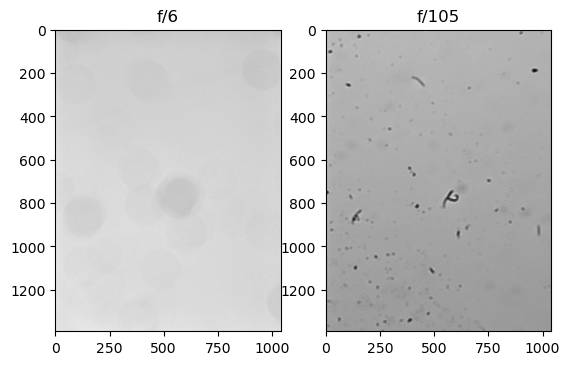

In [6]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(subtracted[0], cmap='gray')
ax[1].imshow(subtracted[-1], cmap='gray')
ax[0].set_title('f/6')
ax[1].set_title('f/105')

In [7]:
subtracted.shape

(7, 1392, 1040)

In [8]:
cropped_square = subtracted[:, 400:600, 750:1000]
mean_values = np.mean(np.reshape(cropped_square, (7,-1)).T, axis=0)
std_values = np.std(np.reshape(cropped_square, (7,-1)).T, axis=0) 
std_values

array([306.65209392, 330.10082107, 325.5614645 , 341.7621169 ,
       393.64127091, 384.34979233, 590.63345103])

Calculate intensities

In [9]:
intensities = mean_values/exposure_times
intensities_std = std_values/exposure_times/intensities[0]
intensities/= intensities[0]

In [10]:
def calibration_curve(N):
    return 36/N**2
    

Text(0.5, 0, 'f number')

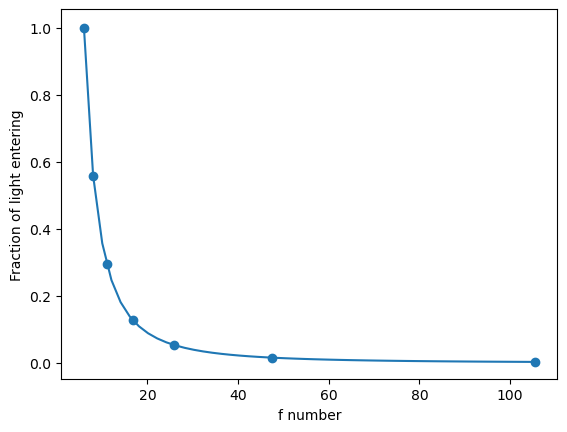

In [11]:
# plt.plot(exposures)
fig, ax1 = plt.subplots()

Ns = np.linspace(6,105)
ax1.plot(Ns, calibration_curve(Ns))
ax1.errorbar(6/np.sqrt(intensities), intensities, marker='o', ls='', color='tab:blue', yerr= intensities_std)
# ax1.plot(Ns, Ns*550e-9)
ax1.set_ylabel('Fraction of light entering')
ax1.set_xlabel('f number')

In [12]:
f_numbers = 6/np.sqrt(intensities)
f_numbers, np.log(f_numbers/6)/np.log(np.sqrt(2)) + 1

(array([  6.        ,   8.0326921 ,  11.02426219,  16.71845468,
         25.92260749,  47.376144  , 105.44477882]),
 array([1.        , 1.84184215, 2.7552954 , 3.95681419, 5.22235287,
        6.96225275, 9.2707627 ]))

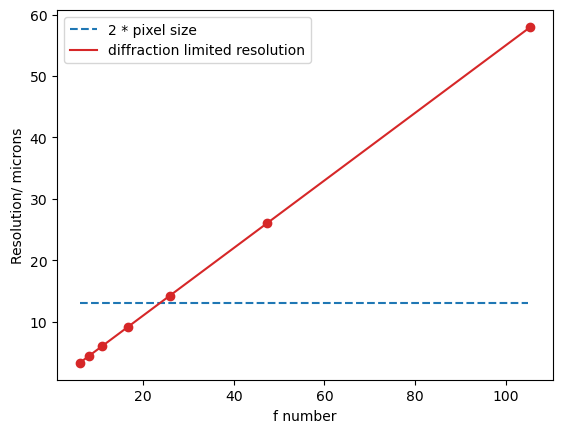

In [13]:
wavelength = 560e-3 # (um)
plt.plot(Ns, 13 + Ns*0, ls='--', label='2 * pixel size')
plt.plot(Ns, Ns*wavelength, color='tab:red', label='diffraction limited resolution')
plt.scatter(f_numbers, f_numbers*wavelength, color='tab:red')
plt.ylabel('Resolution/ microns')
plt.xlabel('f number')
plt.legend()

In [6]:
len(np.arange(9.45, 15.65, 0.25))

25

Obtain the NAs

In [16]:
NAs = 1/(2*f_numbers)
NAs

array([0.08333333, 0.06224563, 0.04535451, 0.02990707, 0.01928818,
       0.01055383, 0.00474182])

In [17]:
for i in range(len(NAs)):
    print(f_numbers[i], NAs[i])

6.0 0.08333333333333333
8.03269210065695 0.0622456324398526
11.024262191475653 0.045354509110516035
16.71845467567506 0.029907070342301896
25.922607492932016 0.019288183109524324
47.37614400397969 0.010553834857433712
105.44477882374461 0.004741818471977366
